## Strikes Per Flight, According to Time of Day

### Goal

The goal of this notebook is look for time-of-day patterns in the frequency of bird strikes.

We find the number of bird strikes per flight for each hour of the day. In other words, for each hour (0 to 23), we take the number of bird strikes reported for that hour and divide by the number of flights scheduled to arrive during that hour. 

### Data sources

The bird strike data comes from the FAA Wildlife Strike Database: https://wildlife.faa.gov/search

The flight data comes from the FAA Aviation System Performance Metrics website: https://aspm.faa.gov/apm/sys/AnalysisAP.asp

From both data sets, we use all available data from 2000 to 2019.

### Caveats

1. Approximately half of the strike reports do not have a specific time associated to them. We do not consider these reports here. Therefore, when we talk about the number of strikes reported in a given hour, this is probably lower than the actual number of strikes that occured during that hour.


2. For simplicity, when considering the number of flights in a given hour, we have only worked with scheduled arrival times. Since bird strikes can happen at other parts of the flight (not just arrival), and because many flights are delayed for reasons unrelated to bird strikes, it might be worth considering a more sophisticated way to measure number of flights.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
# Load in the strike data
strikes = pd.read_csv("strikes_2000_2019.csv")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14,16,77,86,96,99) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Make a smaller data frame to focus on the strike time and place
strike_times = strikes[['INDX_NR','INCIDENT_DATE ','STATE',
                        'AIRPORT_ID', 'OPERATOR_ID','SPECIES_ID',
                        'DAMAGE','COST_REPAIRS',
                        'INCIDENT_MONTH','INCIDENT_YEAR',
                        'TIME_OF_DAY','TIME',
                        'FAAREGION','ENROUTE','LOCATION',
                        'HEIGHT','SPEED','DISTANCE',
                        'PHASE_OF_FLIGHT',
                        'EFFECT_NONE', 'EFFECT_ABORTED', 
                        'EFFECT_PREC_LAND', 'EFFECT_ENG_SHUT', 
                        'EFFECT_OTH', 'EFFECT_OTHER',
                        'SKY', 'PRECIP_FOG', 'PRECIP_RAIN', 
                        'PRECIP_SNOW', 'PRECIP_NONE', 
                        'BIRDS_SEEN', 'BIRDS_STRUCK', 'SIZE', 
                        'WARNED', 'REMARKS', 'AOS',
                        'OTHER_COST', 'COST_REPAIRS_INFL_ADJ', 
                        'COST_OTHER_INFL_ADJ','COMMENT',
                        'INDICATED_DAMAGE']]

In [4]:
# Convert the 'INCIDENT_DATE ' column to datetime format
strike_times['INCIDENT_DATE '] = pd.to_datetime(strike_times['INCIDENT_DATE '])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
# In the TIME column in the original data set, 
# empty entries are denoted by the string '     '.
# Here we replace all strings of 5 spaces with NaN
# to make empty entries in the TIME column easier to identify.
strike_times = strike_times.replace('     ', np.nan)

# Convert the times in the 'TIME' column to datetime format
# Unfortunately this assigns a date of 1900-01-01
strike_times['TIME'] = pd.to_datetime(strike_times['TIME'], 
                                      format= '%H:%M')

In [6]:
# The approach is the phase of flight with the most bird strikes
# Therefore, we'll use scheduled arrivals as our estimate for number of flights
strike_times['PHASE_OF_FLIGHT'].value_counts()

Approach        54836
Landing Roll    22306
Take-off Run    21600
Climb           19228
En Route         3278
Descent          1634
Departure        1528
Local             660
Arrival           528
Taxi              416
Parked            109
Unknown            43
Name: PHASE_OF_FLIGHT, dtype: int64


### Toy example: 2018

Let's start by looking at the data from 2018 alone.

In [7]:
# Load in the flight data
# The first line of the data file from FAA ASPM contains title information,
# and the last line of the data file is a "Total:" row
# Use skiprows = [0, 26] to avoid reading in these two lines
flights_2018 = pd.read_csv("flights_hourly/flights_hourly_2018.csv", 
                           skiprows = [0, 26])

In [8]:
flights_2018.head()

,Hour,ScheduledDepartures,ScheduledArrivals,DeparturesFor MetricComputation,ArrivalsFor MetricComputation,% On-TimeGateDepartures,% On-TimeAirportDepartures,% On-TimeGateArrivals,AverageGateDepartureDelay,AverageTaxiOutTime,AverageTaxiOutDelay,AverageAirportDepartureDelay,AverageAirborneDelay,AverageTaxiInDelay,AverageBlockDelay,AverageGateArrivalDelay
0,0,31874,97603,40015,141108,77.31,69.42,78.86,10.28,16.61,4.85,13.85,2.02,2.41,3.82,10.32
1,1,16940,21609,27804,45034,78.34,71.98,78.07,9.75,15.84,4.22,12.78,2.29,1.77,3.92,10.77
2,2,5890,5266,28592,18915,72.18,68.81,75.41,12.83,13.11,2.75,14.73,2.04,1.67,3.90,12.57
3,3,4399,2350,55006,14473,59.35,54.46,70.68,17.66,14.04,3.11,20.25,2.13,1.79,3.62,15.13
4,4,3066,17232,44859,44018,54.90,49.10,74.64,20.19,14.60,3.72,23.38,1.31,1.98,3.13,11.96


In [9]:
strike_times_2018 = strike_times.loc[strike_times['INCIDENT_DATE '].dt.year == 2018]

In [10]:
# Reported strikes each hour
strikes_hourly_2018 = strike_times_2018['TIME'].groupby(strike_times_2018['TIME'].dt.hour).count()

# Flights scheduled to arrive each hour
flights_hourly_2018 = flights_2018['ScheduledArrivals']

# Strikes per flight each hour
strikes_per_flight_hourly_2018 = [strikes_hourly_2018[h]/flights_hourly_2018[h] for h in range(0,24)]

<BarContainer object of 24 artists>

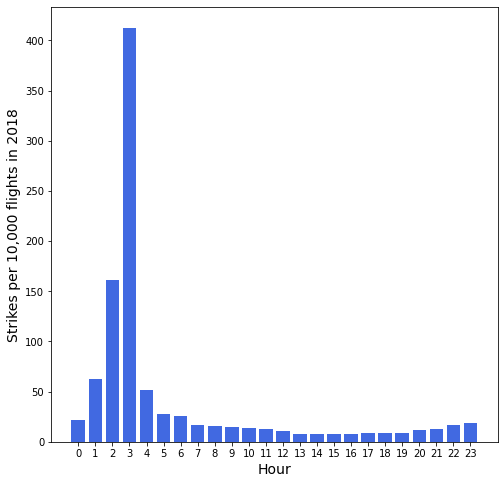

In [11]:
# Plot the strikes per flight for each hour of the day

plt.figure(figsize=(8,8))

plt.xlabel('Hour', fontsize=14)
plt.ylabel('Strikes per 10,000 flights in 2018', fontsize=14)

plt.xticks(range(0,24))

plt.bar(range(0,24), 
        [10000*i for i in strikes_per_flight_hourly_2018],
        color='royalblue')

### Strikes reported per 10,000 flights, each hour: 2000-2019

We'll do something similar to the above, but with the whole data set.

In [12]:
# Load in the flight data for each year from 2000 through 2019
# Store it as a list called flights,
# where flights[i] = the data frame for the year 2000+i

flights = []

for year in range(0, 20):
    flight_df = pd.read_csv("flights_hourly/flights_hourly_{}.csv".format(str(2000+year)), skiprows = [0, 26])
    flights.append(flight_df)

In [13]:
# Reported strikes each hour
strikes_hourly = strike_times['TIME'].groupby(strike_times['TIME'].dt.hour).count()

# Flights scheduled to arrive each hour
flights_hourly = sum([flights[y]['ScheduledArrivals'] for y in range(0,20)])

# Strikes per flight each hour
strikes_per_flight_hourly = [strikes_hourly[h]/flights_hourly[h] for h in range(0,24)]

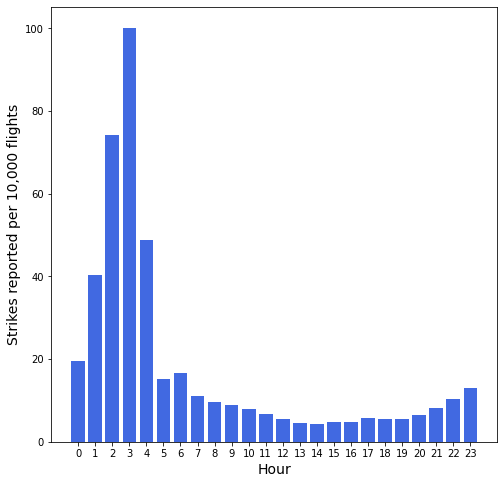

In [14]:
# Plot the strikes per flight for each hour of the day

plt.figure(figsize=(8,8))

plt.xlabel('Hour', fontsize=14)
plt.ylabel('Strikes reported per 10,000 flights', fontsize=14)

plt.xticks(range(0,24))

plt.bar(range(0,24), 
        [10000*i for i in strikes_per_flight_hourly],
        color='royalblue')

plt.show()

For comparison, let's plot the bird strikes and the number of flights separately.

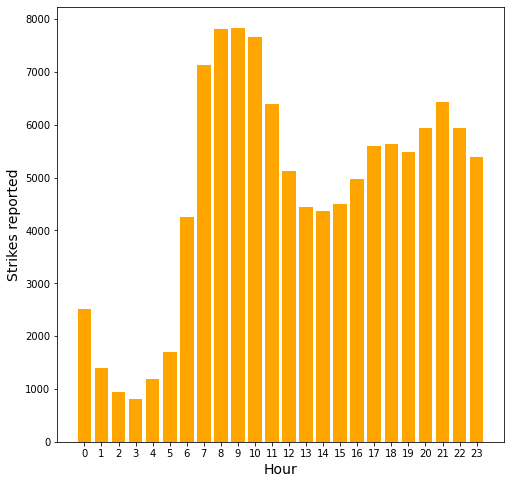

In [15]:
# Plot the number of bird strikes by hour

plt.figure(figsize=(8,8))

plt.xlabel('Hour', fontsize=14)
plt.ylabel('Strikes reported', fontsize=14)

plt.xticks(range(0,24))

plt.bar(range(0,24), strikes_hourly, color='orange')

plt.show()

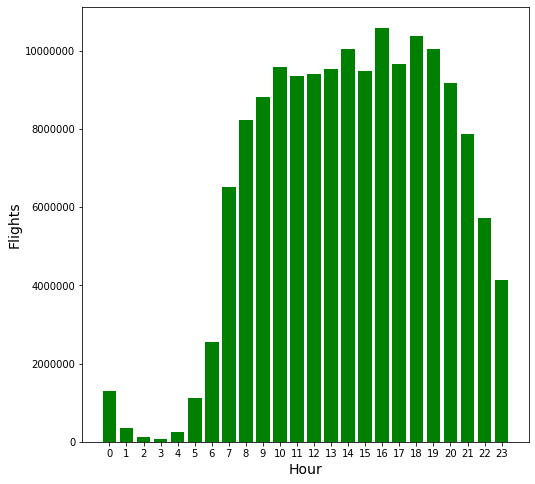

In [16]:
# Plot the number of flights by hour

plt.figure(figsize=(8,8))

plt.xlabel('Hour', fontsize=14)
plt.ylabel('Flights', fontsize=14)

# Write the y-axis labels in plain text
# instead of scientific notation
plt.ticklabel_format(style = 'plain')

plt.xticks(range(0,24))

plt.bar(range(0,24), flights_hourly, color='g')

plt.show()

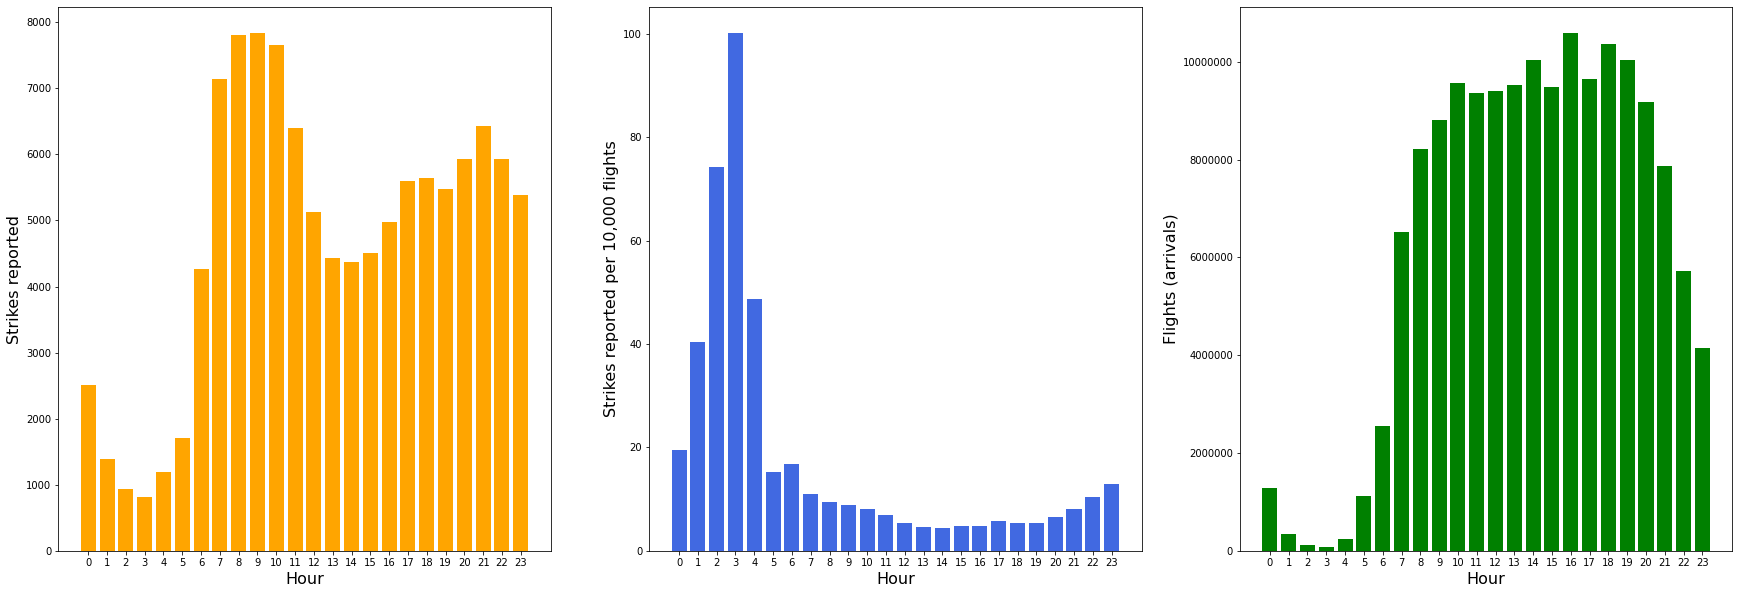

In [17]:
# Now let's plot these three side-by-side

fig, ax = plt.subplots(1,3,sharex=True, figsize=(30,10))

ax[0].set_xticks(range(0,24))

ax[0].bar(range(0,24), strikes_hourly, color='orange')
ax[0].set_xlabel('Hour', fontsize=16)
ax[0].set_ylabel('Strikes reported', fontsize=16)

ax[1].bar(range(0,24), [10000*i for i in strikes_per_flight_hourly], color='royalblue')
ax[1].set_xlabel('Hour', fontsize=16)
ax[1].set_ylabel('Strikes reported per 10,000 flights', fontsize=16)

ax[2].bar(range(0,24), flights_hourly, color='g')
ax[2].ticklabel_format(style = 'plain')
ax[2].set_xlabel('Hour', fontsize=16)
ax[2].set_ylabel('Flights (arrivals)', fontsize=16)

plt.show()

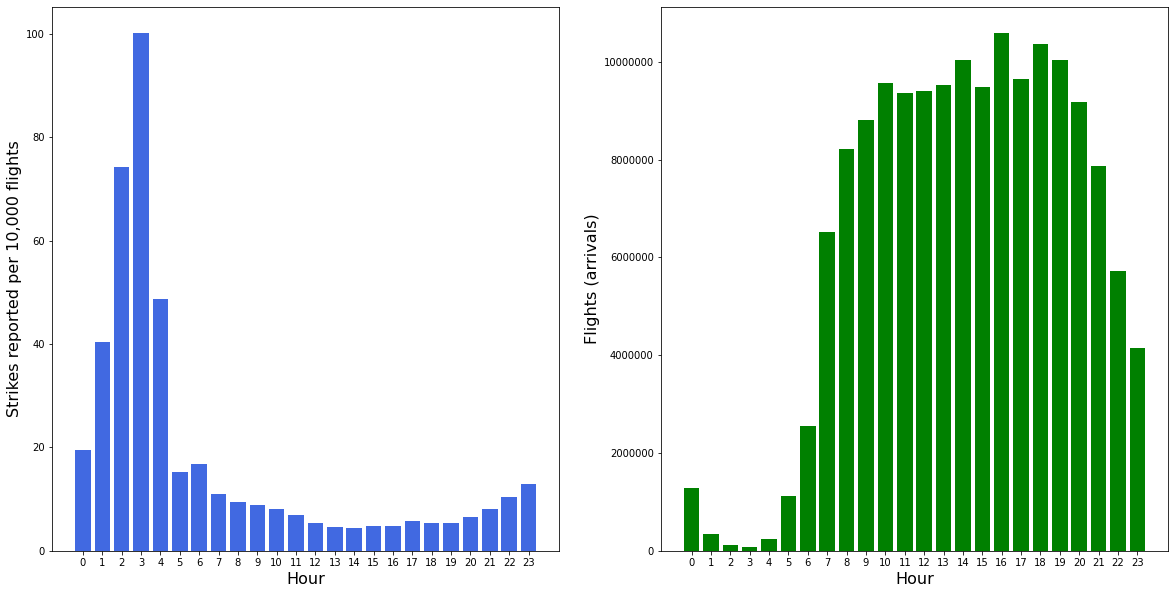

In [18]:
# Plot the graphs for strikes per flight and number of flights

fig, ax = plt.subplots(1,2,sharex=True, figsize=(20,10))

ax[0].set_xticks(range(0,24))

ax[0].bar(range(0,24), [10000*i for i in strikes_per_flight_hourly], color='royalblue')
ax[0].set_xlabel('Hour', fontsize=16)
ax[0].set_ylabel('Strikes reported per 10,000 flights', fontsize=16)

ax[1].bar(range(0,24), flights_hourly, color='g')
ax[1].ticklabel_format(style = 'plain')
ax[1].set_xlabel('Hour', fontsize=16)
ax[1].set_ylabel('Flights (arrivals)', fontsize=16)

plt.show()

## Density Estimation

The strike per flight data given us some useful information about probability. In particular, we are interested in answering the following question: for a given flight arriving at hour $h$, what is the probability that a bird strike will occur?

One way we can approximate this probability is to take it to be the number of strikes per flight for hour $h$.

We'd like to model this probability in some way. To do this, we will use kernel density estimation.

In [19]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity()

First, we'll apply KDE to the number of strikes per hour, without accounting for number of flights.

In [20]:
strike_hours = strike_times['TIME'].dt.hour
strike_hours = strike_hours.dropna()

strike_hours

0          8.0
1         19.0
4         11.0
5         18.0
11         4.0
          ... 
205808    10.0
205809    11.0
205810    12.0
205811     7.0
205812    10.0
Name: TIME, Length: 113484, dtype: float64

In [21]:
# Fit the model
X = np.array(strike_hours).reshape(-1,1)
kde.fit(X)

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

In [22]:
# Used https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
# for help plotting

X_plot = np.linspace(0,23,24).reshape(-1,1)
log_dens = kde.score_samples(X_plot)

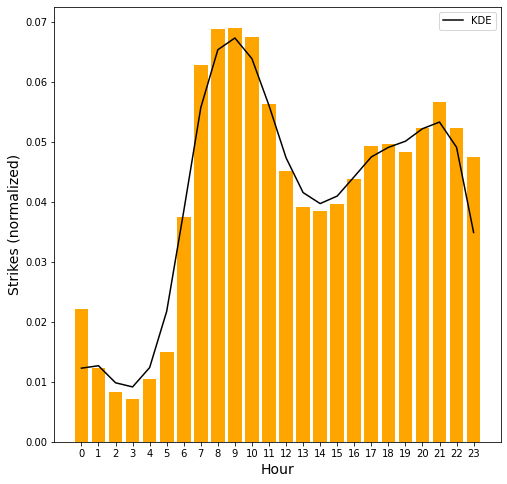

In [23]:
# Normalize the strikes_hourly values so they add up to 1
# This is to make it comparable to the KDE curve on the graph
strikes_hourly_array = np.array(strikes_hourly)/sum(strikes_hourly)

plt.figure(figsize=(8,8))

# Plot the hourly strikes as a histogram
plt.bar(range(0,24), strikes_hourly_array, color='orange')

# Plot the KDE curve
plt.plot(X_plot, np.exp(log_dens), color = 'k', label = 'KDE')

plt.xticks(range(0,24))
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Strikes (normalized)', fontsize=14)

plt.legend()

plt.show()

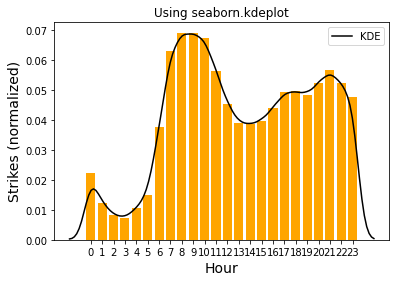

In [24]:
# There's also a built-in KDE plot from seaborn

import seaborn as sns

plt.bar(range(0,24), strikes_hourly_array, color='orange')
sns.kdeplot(strike_hours, color='k', label='KDE')

plt.xticks(range(0,24))
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Strikes (normalized)', fontsize=14)

plt.title('Using seaborn.kdeplot')

plt.show()

Next, we'll apply KDE to the strikes per flight data. To get this to work, we'll make a list of "data points" as follows. If there were $n$ strikes reported per 10,000 flights in hour $h$ (where $n$ is rounded to the nearest integer), include $n$ entries of $h$ in the list.

In [25]:
# Strikes reported per 10,000 flights
spfh_scaled = [10000*i for i in strikes_per_flight_hourly]

In [26]:
# Make a list of mock data points.
# If there were n strikes reported per 10,000 flights in hour h, 
# include n entries of h in the list.
spfh_points = []
for h in range(0,24):
    spfh_points.extend([h]*int(np.round(spfh_scaled[h], 0)))

In [27]:
# Kernel Density Estimation
kde = KernelDensity()

# Fit the model
X = np.array(spfh_points).reshape(-1,1)
kde.fit(X)

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

In [28]:
X_plot = np.linspace(0,23,24).reshape(-1,1)
log_dens = kde.score_samples(X_plot)

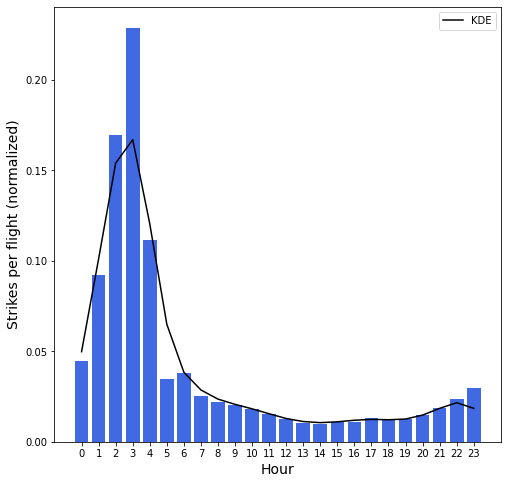

In [29]:
# Normalize the strikes_hourly values so they add up to 1
# This is to make it comparable to the KDE curve on the graph
spfh_scaled_normalized = np.array(spfh_scaled)/sum(spfh_scaled)

plt.figure(figsize=(8,8))

# Plot the hourly strikes as a histogram
plt.bar(range(0,24), spfh_scaled_normalized, color='royalblue')

# Plot the KDE curve
plt.plot(X_plot, np.exp(log_dens), color = 'k', label = 'KDE')

plt.xticks(range(0,24))
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Strikes per flight (normalized)', fontsize=14)

plt.legend()

plt.show()

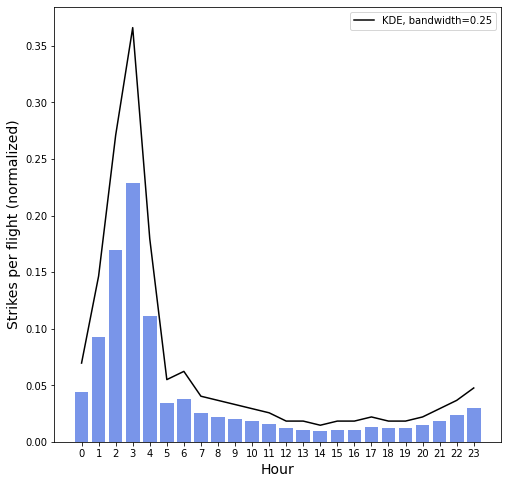

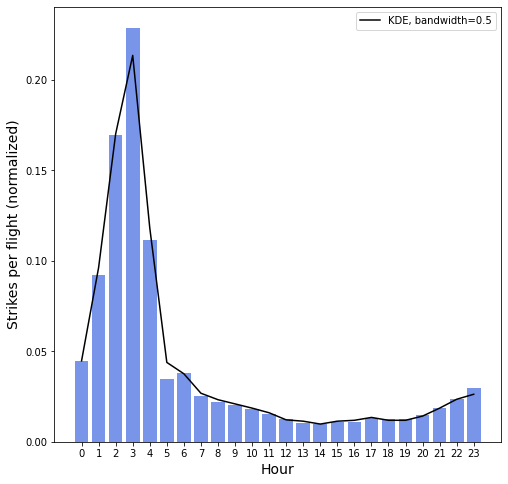

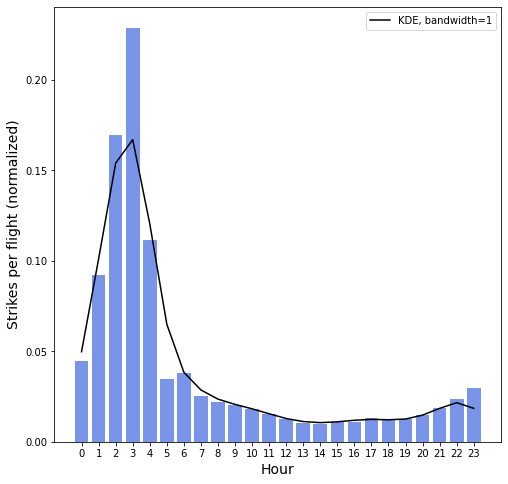

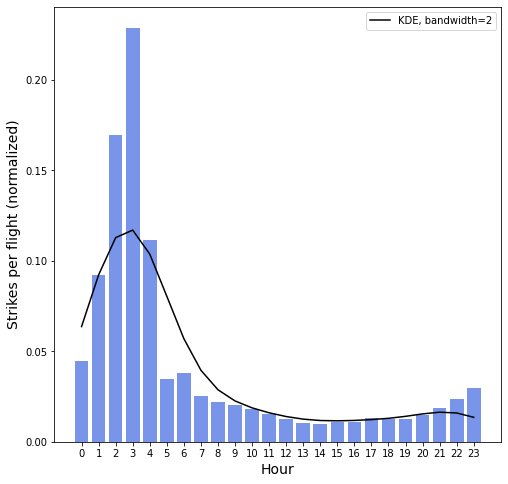

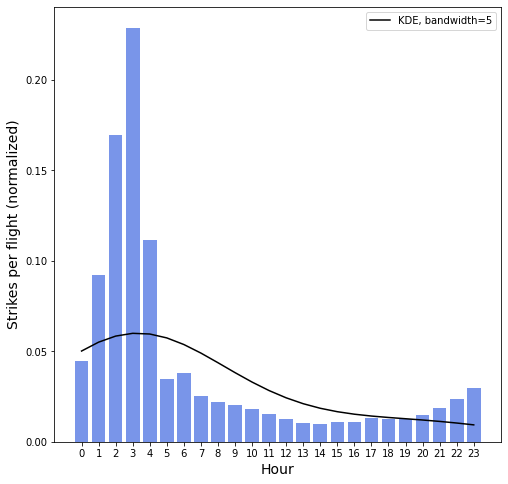

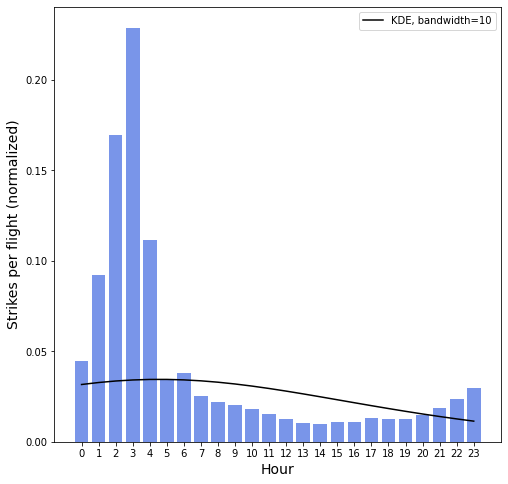

In [30]:
# Let's see how the curve varies depending on bandwith

for b in [.25, .5, 1, 2, 5, 10]:
    
    plt.figure(figsize=(8,8))

    # Kernel Density Estimation
    kde = KernelDensity(bandwidth = b)

    # Fit the model
    X = np.array(spfh_points).reshape(-1,1)
    kde.fit(X)
    
    # Plot the hourly strikes as a histogram
    plt.bar(range(0,24), spfh_scaled_normalized, color = 'royalblue', alpha=.7)

    # Plot the KDE curve
    X_plot = np.linspace(0,23,24).reshape(-1,1)
    log_dens = kde.score_samples(X_plot)
    plt.plot(X_plot, np.exp(log_dens), color = 'k', label = 'KDE, bandwidth={}'.format(str(b)))

    # Label the axes
    plt.xticks(range(0,24))
    plt.xlabel('Hour', fontsize=14)
    plt.ylabel('Strikes per flight (normalized)', fontsize=14)
    
    plt.legend()

    plt.show()